<a href="https://colab.research.google.com/github/hdperezn/MIDI_functions/blob/main/UNetLIke_pianorolls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git
from gcpds.image_segmentation.losses import DiceCoefficient

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git to /tmp/pip-req-build-xqg5_8ld
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git /tmp/pip-req-build-xqg5_8ld
  Resolved https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git to commit 537c809aed21aba452a28716370b343501633e3c
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-image-segmentation: filename=gcpds_image_segmentation-0.1a0-py3-none-any.whl size=33684 sha256=aaf0751c518c18461612655b1d03c24f9f76a0d43c86efa0366c33d889e0f03e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ccpbq280/wheels/93/3d/96/2bc458dca20d46cfdf8f50c9871f921c847eb0324c71eb3f60
Successfully built gcpds-image-segmentation


In [ ]:
!git clone https://github.com/hdperezn/MIDI_functions.git
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Cloning into 'MIDI_functions'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 96 (delta 22), reused 56 (delta 3), pack-reused 0
Unpacking objects: 100% (96/96), 4.71 MiB | 4.13 MiB/s, done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 23 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2

In [ ]:
import os
import time
import string 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import fluidsynth
import glob
import pathlib
import pretty_midi
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from IPython import display
from MIDI_functions.MIDI_functions import *
from typing import Dict, List, Optional, Sequence, Tuple

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1_l2
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin


# Create Train test files 

paths from the MIDI data

In [ ]:
path_midi = '/content/MIDI_functions/deap_midis'
data_dir = pathlib.Path(path_midi)
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Sampling rate (_SAMPLING_RATE) for audio playback and frequency (fProll) to create piano rolls


In [ ]:
_SAMPLING_RATE = 16000
fProll = 20

Number of files: 40


windowed piano roll arrays

In [ ]:
Prolls_windowed = []
for i in range(len(filenames)):   
  #load MIDI and create array
  Proll = pretty_midi.PrettyMIDI(filenames[i]).get_piano_roll(fs=fProll) 
  if i in [0, 13, 16, 21, 39]:
    Proll_cut = cut_midi_secTrial(Proll, 9)
  elif i in [9, 11]:
    Proll_cut = cut_midi_secTrial(Proll, 8)
  else:
    Proll_cut = cut_midi_secTrial(Proll, 10)     
  Prolls_windowed.append(Proll_cut) 

calculate te mode to cut any sample at the same Length


In [ ]:
midi_lens = []
for i in range(len(Prolls_windowed)):
  midi_lens.append(Prolls_windowed[i].shape[2])
from statistics import mode
mode(midi_lens)

119

Create array with equal dims 128 padding last samples

In [ ]:
Prolls_cut = []
Prolls_trial_len = 128 #64, 59
for i in range(len(Prolls_windowed)):
  if Prolls_windowed[i].shape[2] >= Prolls_trial_len:
    x = Prolls_windowed[i][:,:,0:Prolls_trial_len]
    Prolls_cut.append(x)
  else:
    dif = Prolls_trial_len - Prolls_windowed[i].shape[2]
    x = np.concatenate( (Prolls_windowed[i][:,:,:],Prolls_windowed[i][:,:,-dif::] ), axis = 2)
    Prolls_cut.append(x)


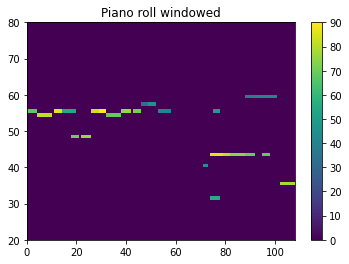

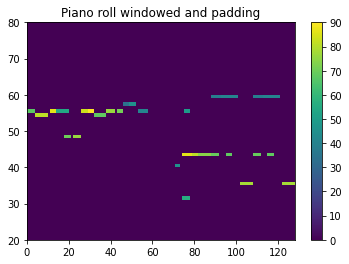

In [ ]:
song = 2

plt.figure()
plt.pcolormesh(Prolls_windowed[song][0,:,:])
plt.colorbar()
plt.ylim(20,80)
plt.title("Piano roll windowed")
plt.show()

plt.figure()
plt.pcolormesh(Prolls_cut[song][0,:,:])
plt.colorbar()
plt.ylim(20,80)
plt.title("Piano roll windowed and padding")
plt.show()

Create a training array with dims (samples, time, notes), create raget mask   and spliting in traint and test sets


In [ ]:
Prolls_array = np.concatenate(np.asarray(Prolls_cut), axis = 0)
Prolls_array_mask = np.where(Prolls_array>0,1,0)
print('these are de dims of the piano roll array to use in the neural network: ', Prolls_array.shape)


these are de dims of the piano roll array to use in the neural network:  (391, 128, 128)


<ipython-input-217-e67c84362ec8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Prolls_array = np.concatenate(np.asarray(Prolls_cut), axis = 0)


In [ ]:
#train_test_data

X_train = Prolls_array[0:313,8:88,:,np.newaxis].astype('float32').transpose(0,2,1,3)
X_test = Prolls_array[313::,8:88,:, np.newaxis].astype('float32').transpose(0,2,1,3)


y_train = Prolls_array_mask[0:313,8:88,:,np.newaxis].astype('float32').transpose(0,2,1,3)
y_test = Prolls_array_mask[313::,8:88,:,np.newaxis].astype('float32').transpose(0,2,1,3)


X_dims = X_train.shape
print(X_dims)

(313, 128, 80, 1)


# Load Model

In [ ]:
img_size = X_dims[-3::]
num_classes = 1
loss = DiceCoefficient()

UNet_pianoroll = UNet_MIDI(img_size, loss, num_classes, epochs=250,batch_size=32,
               learning_rate=1e-3, droprate = 0.6)